# Least Squares GAN


기존 GAN은 진짜와 가짜를 구별하는 판별자의 Loss를 이용해서 학습을 하나 이런 학습 과정에서 vanishing gradient 문제가 발생 할 수 있다는 것을 인지하고 least square loss를 적용한 모델을 제안  

1. LSGAN의 목적함수를 최소화하는 것이 Pearson $χ^2$ diviergence를 최소화 하는것을 보임  
2. LSGAN이 보통의 GAN보다 더 좋은 이미지를 생성  
3. LSGAN은 학습을 더 안정적으로 수행

## Pearson  χ2  diviergence

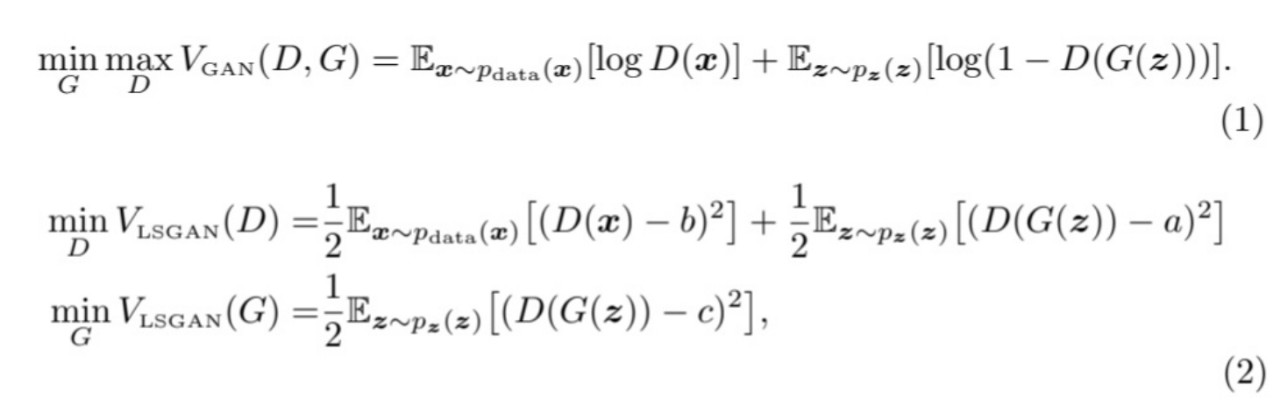

(1) 은 기존 GAN 의 목적함수를,  
(2) 는 LSGAN의 목적함수 이다. sigmoid loss가 아닌 least square loss 를 적용  
a : fake data label, b : real data label,  
c : D가 fake data를 진짜라고 믿게 하고 싶은 값 

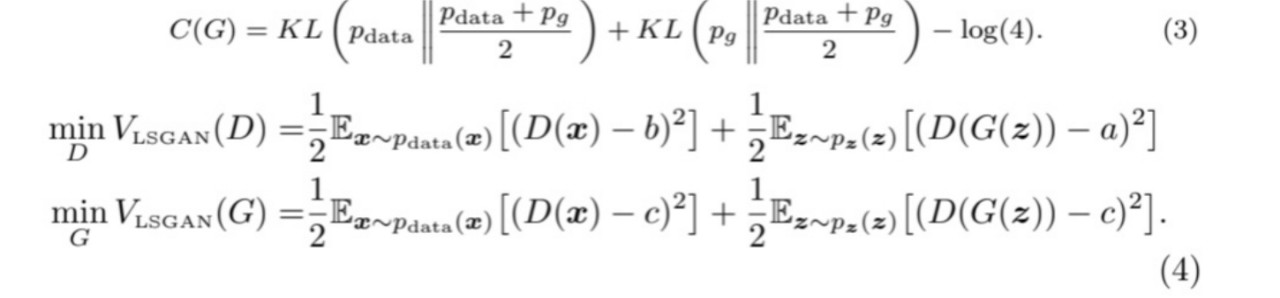

GAN 에서는 목적함수를 최소화 하기위해 (3)의 식을 JSD를 이용하여 최소화함  
(4) 는 (2) 식에 항을 하나 추가하여 얻은 식으로 이를 이용하여 이후에 식전개

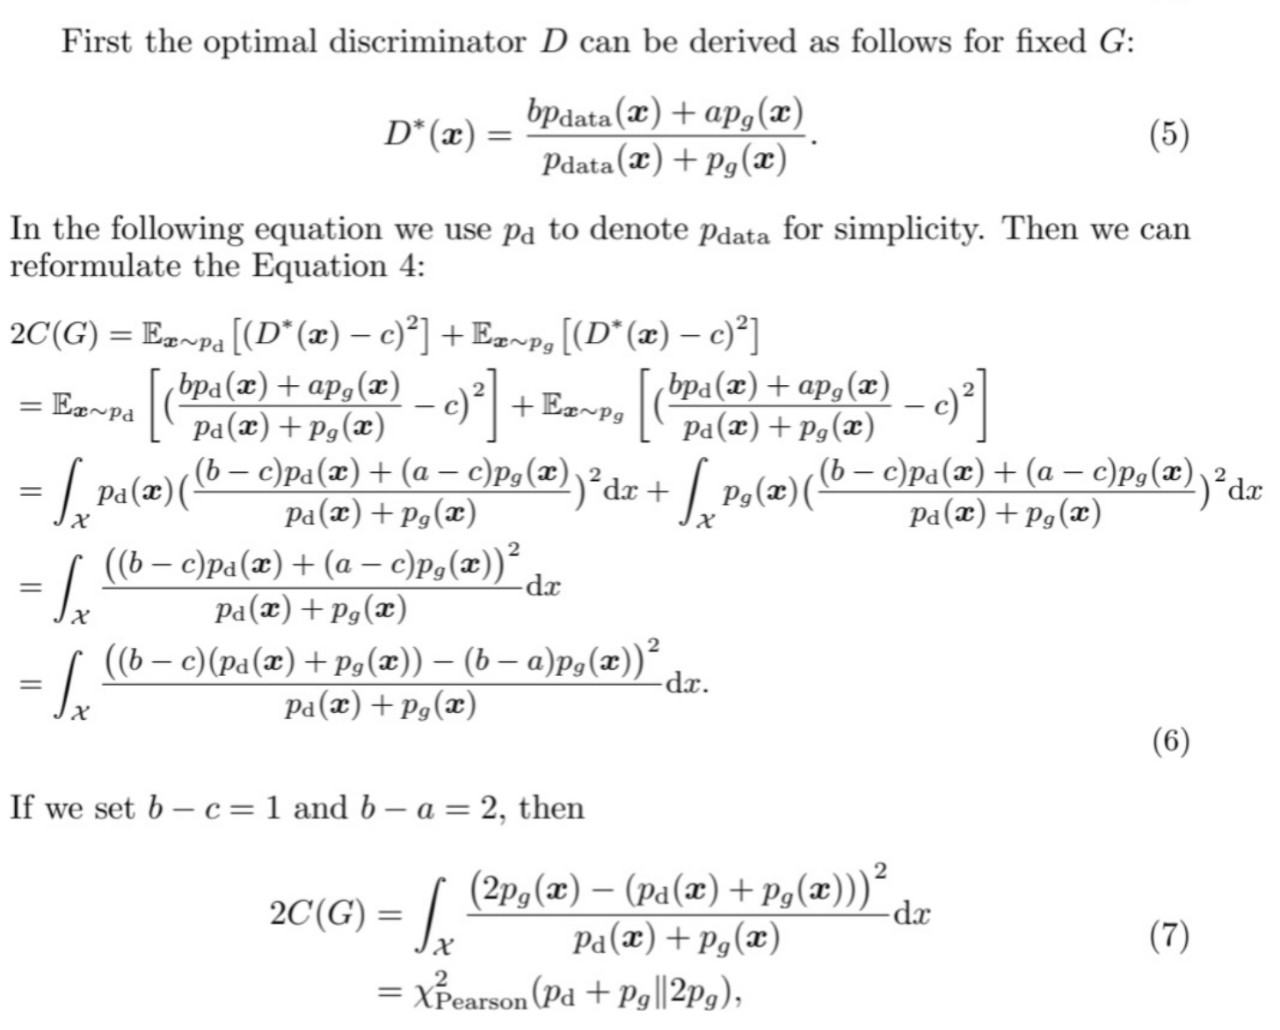

위와 같은 전개를 하면 b - c = 1, b - a = 2로 했을 때,  
(4) 의 식을 최소화하면 Pearson χ2 diviergence 을 최소화하는것을 알 수 있다.

## Why least square loss ?

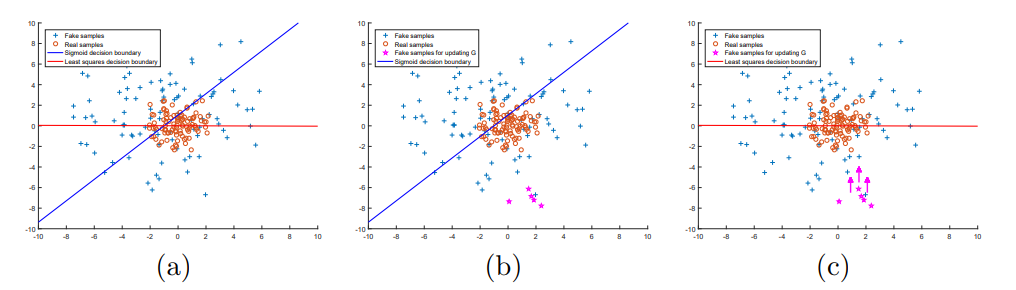

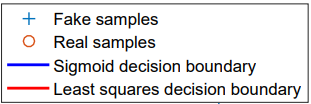

(a) : 두개의 Loss 에 대한 결정 경계  
(b) : 시그모이드 Loss 에 대한 결정 경계  
(c) : 최소제곱 Loss 에 대한 결정 경계  
별표는 생성자를 업데이트 하기위한 fake sample을 의미  

결정 경계가 실제 데이터 분포를 가로질러야 모델이 학습이 잘 된것인데, least square loss 의 경우 결정 경계에서 멀리 있는 샘플들에 대해 패널티를 부여하여 결정 경계로 이동 시키는 특성이 있어 LSGAN에서는 GAN보다 더 실제같은 이미지를 얻을 수 있다.

## Stable training

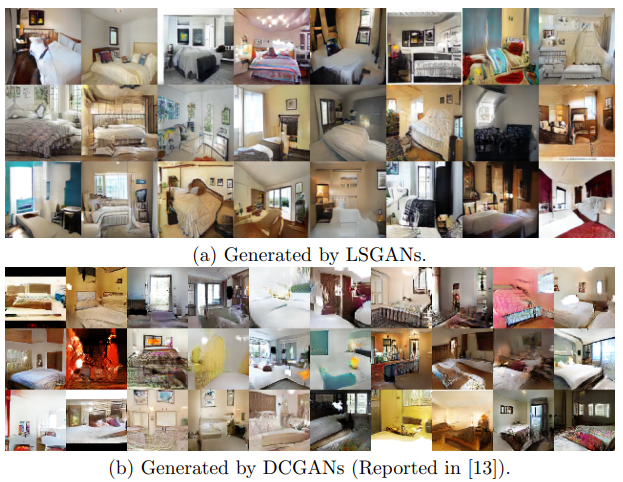

같은 모델 아키텍쳐를 이용하여 LSGAN과 DCGAN에서 생성된 이미지를 비교

## 실습

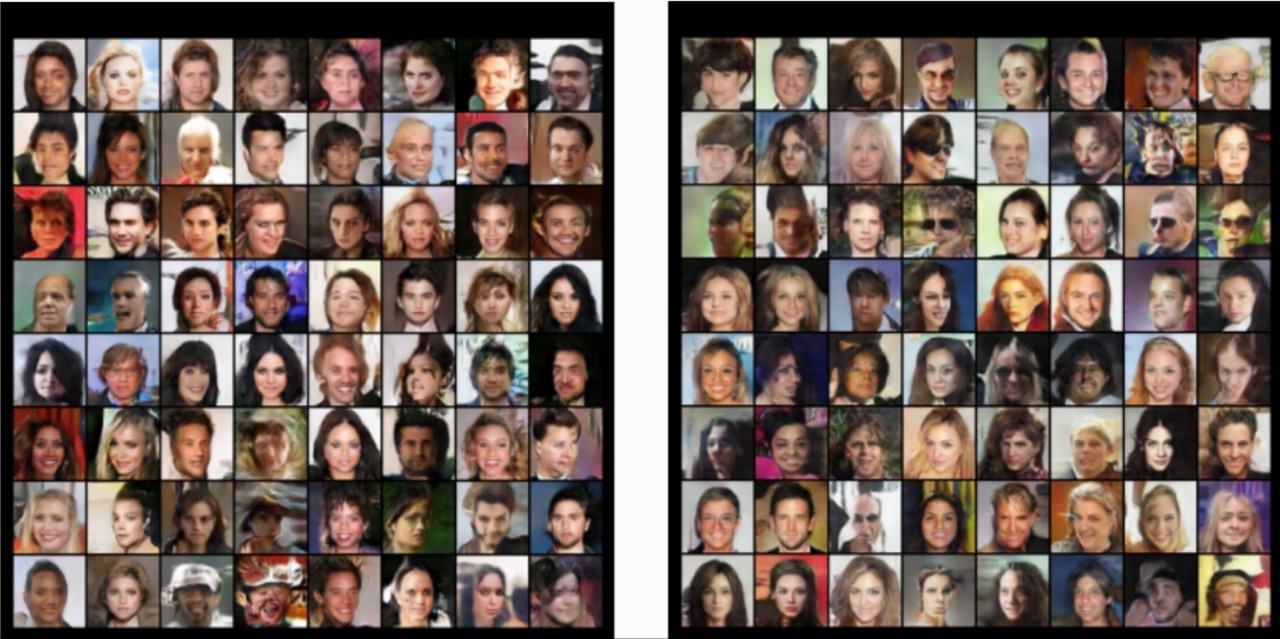

왼쪽이 LSGAN, 오른쪽이 GAN 으로 생성한 이미지

# 코드 실습

In [1]:
# 라이브러리 임포트
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 변수 정의

workers = 16
batch_size = 128
image_size = 64

nc = 3
nz = 100
ngf = 64
ndf = 64

lr = 0.0001
beta1 = 0.5
beta2 = 0.999

ngpu = 1
device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

In [ ]:
file_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA/img_align_celeba')

for file in file_list:
  if not file.endswith('.jpg'):
    print(file)

In [ ]:
# 데이터 로드

folder_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA'
train_dataset = datasets.ImageFolder(root=folder_path,
                                     transform=transforms.Compose([transforms.Resize(image_size),
                                                                   transforms.CenterCrop(image_size),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
# LSGAN 

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 4 * ngf, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 4x4x256
            nn.ConvTranspose2d(4 * ngf, 4 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 8x8x256
            nn.ConvTranspose2d(4 * ngf, 4 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 16x16x128
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 32x32x64
            nn.ConvTranspose2d(2 * ngf,  nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
      return self.main(input)
      
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 32x32x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16x128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8x256
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4x512
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 1x1x1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            #,nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [4]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
# https://github.com/meliketoy/LSGAN.pytorch/blob/master/networks/Discriminator.py

import tqdm
from tqdm.notebook import tqdm as tqdm_nb
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

img_list = []
G_losses = []
D_losses = []

pbar = tqdm_nb()
piter = 0

num_epochs = 150
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        if i % 3 == 0:
          netD.zero_grad()
          
          real_img = data[0].to(device)
          b_size = real_img.size(0)
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          fake_img = netG(noise)
          # Least Square Loss 
          DLoss = 0.5 * torch.mean((netD(real_img) - 1)**2) + 0.5 * torch.mean((netD(fake_img) + 1)**2)
          DLoss.backward()
          optimizerD.step()   
          
        # G 학습
        if i % 2 == 0:
          netG.zero_grad()
          gen_img = netG(noise)
          GLoss = 0.5 * torch.mean((netD(gen_img))**2)
          GLoss.backward()
          optimizerG.step()

          desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                  % (epoch+1, num_epochs, i, epoch_steps, DLoss.item(), GLoss.item())
          pbar.set_description(desc)

          G_losses.append(GLoss.item())
          D_losses.append(DLoss.item())

        # fake image 생성
        #if (piter - 1) % 5 == 0:
        #    with torch.no_grad():
        #        fake = netG(fixed_noise).detach().cpu()
        #   img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
          print(desc)

pbar.refresh()

In [ ]:
torch.save({
    'LSGAN_G' : netG.state_dict(),
    'LSGAN_D' : netD.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/LSGAN_CelebA_100epochs')

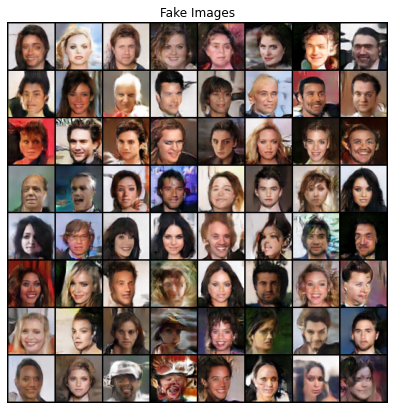

In [ ]:
# Generated Images

#for epoch in range(1,41,2):
fake = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(7, 7))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()

In [ ]:
# GAN Training

import tqdm
from tqdm.notebook import tqdm as tqdm_nb
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

adversarial_loss = nn.BCELoss()
img_list = []
G_losses = []
D_losses = []

pbar = tqdm_nb()
piter = 0

num_epochs = 100
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        if i % 1 == 0:
          netD.zero_grad()
          
          real_img = data[0].to(device)
          b_size = real_img.size(0)
          real_label = torch.cuda.FloatTensor(b_size,1,1,1).fill_(1.0)
          fake_label = torch.cuda.FloatTensor(b_size,1,1,1).fill_(0.0)
          #real_label = torch.FloatTensor(b_size,1).fill_(1.0)
          #fake_label = torch.FloatTensor(b_size,1).fill_(0.0)

          noise = torch.randn(b_size, nz, 1, 1, device=device)
          fake_img = netG(noise)
         
          DLoss = 0.5 * adversarial_loss(netD(fake_img),
                                         fake_label) + 0.5 * adversarial_loss(netD(real_img),
                                                                              real_label)
          DLoss.backward()
          optimizerD.step()   
          
        # G 학습
        if i % 2 == 0:
          netG.zero_grad()
          gen_img = netG(noise)
          GLoss = adversarial_loss(netD(gen_img),real_label)
          GLoss.backward()
          optimizerG.step()

          desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                  % (epoch+1, num_epochs, i, epoch_steps, DLoss.item(), GLoss.item())
          pbar.set_description(desc)

          G_losses.append(GLoss.item())
          D_losses.append(DLoss.item())

        # fake image 생성
        #if (piter - 1) % 5 == 0:
        #    with torch.no_grad():
        #        fake = netG(fixed_noise).detach().cpu()
        #   img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
          print(desc)

pbar.refresh()

In [ ]:
torch.save({
    'GAN_G' : netG.state_dict(),
    'GAN_D' : netD.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/GAN_CelebA_100epochs')

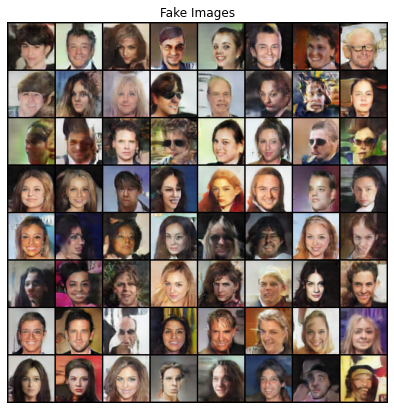

In [ ]:
# Generated Images

#for epoch in range(1,41,2):
fake = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(7, 7))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()

In [5]:
# load params

state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/LSGAN_CelebA_100epochs')
netG.load_state_dict(state_dict['LSGAN_G'])

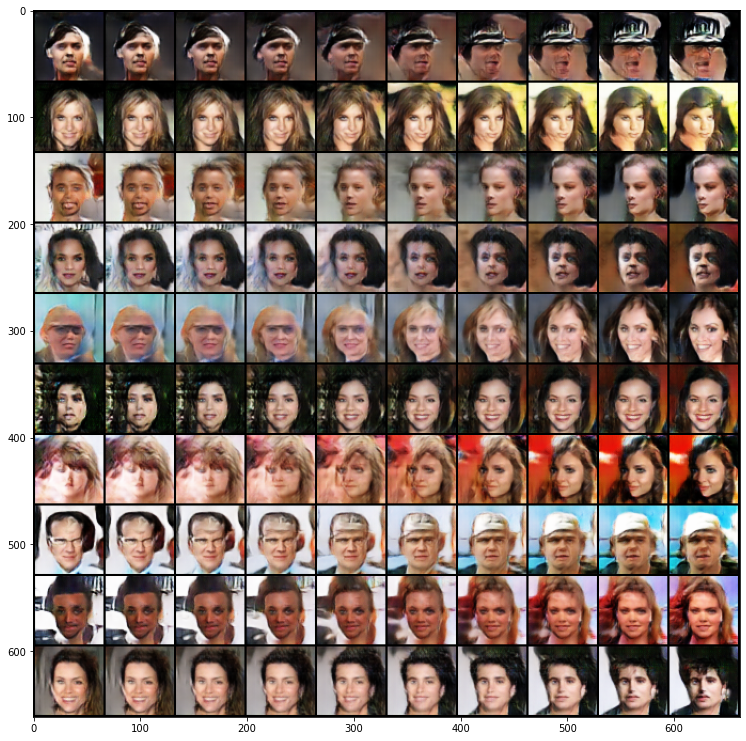

In [45]:
X = []
for _ in range(10):
  a = torch.randn(nz,1,1)
  b = torch.randn(nz,1,1)
  X.append(np.linspace(a,b,10))
X = torch.Tensor(np.array(X).reshape(100,100,1,1)).to(device)
images = netG(X).detach().cpu()
plt.figure(figsize=(13,13))
plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True, nrow=10),(1,2,0)))
plt.show()